## Model training

While we try to keep training time somewhat reasonable, some models may take a while, especially in cross-validation. Where possible we have used the `n_jobs` parameter to parallelize the training. After tuning the hyperparameters models are stored in the models folder as pickled files though, so they can also be used without retraining.

For runtime reasons we for example only trained one non-linear SVM model and tried to speed up RF parameter search by parallelizing and using warm starts.

In [1]:
# change number of workers when running on a different machine
WORKERS = 8

In [2]:
from sklearn.model_selection import train_test_split  # For splitting the data
from sklearn.linear_model import LogisticRegression  # For training the model
from sklearn.metrics import accuracy_score, classification_report  # For evaluating the model
import joblib
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import numpy as np

In [3]:
data_path = os.path.join("data", "small_data_eda.zip")
# Load data
data = pd.read_csv(data_path)
data.head()

,product,narrative,narrative_len,narrative_prep,narrative_prep_len,text_lemma,word_count,char_count,sentence_count,sentiment
0,credit_card,used third party company book vacation package...,64,party company book vacation package notified c...,53,party company book vacation package notify com...,64,485,1,-0.138095
1,credit_card,company u bank reliacard issue account locked ...,66,company u bank reliacard issue account locked ...,58,company u bank reliacard issue account locked ...,66,421,1,-0.083333
2,credit_card,victim identity fraud personal financial infor...,91,victim identity fraud personal financial infor...,83,victim identity fraud personal financial infor...,91,696,1,-0.002679
3,credit_card,browsing online site invited apply credit card...,70,browsing online site invited apply credit card...,64,browse online site invite apply credit card si...,70,496,1,-0.243056
4,credit_card,made payment credit card balance resulting cre...,20,payment credit card balance resulting credit b...,18,payment credit card balance result credit bala...,20,143,1,0.000000


In [4]:
# Ensure that both 'narrative_prep' and 'product' have no missing values
#data_filtered = data.dropna(subset=['narrative_prep', 'product'])
# Encode the target variable (Product Categories)
le = LabelEncoder()
y = le.fit_transform(data['product'])  

In [5]:
from sklearn.metrics import confusion_matrix

# train and evaluate a model
def train_evaluate_model(X_train, y_train, X_test, y_test, model):
    # train the model
    model.fit(X_train, y_train)

    # predict the labels
    y_pred = model.predict(X_test)

    # evaluate with report and confusion matrix
    report = classification_report(y_test, y_pred, target_names=le.classes_)
    cm = confusion_matrix(y_test, y_pred)
    
    return report, cm


def tune_and_evaluate_model(model, param_grid, X_train, y_train, X_test, y_test):
    # grid search with cv for hyperparameter tuning
    grid_search = GridSearchCV(model, param_grid, refit=True, verbose=2, cv=5, n_jobs=WORKERS)
    grid_search.fit(X_train, y_train)

    print("Best hyperparameters: ", grid_search.best_params_)

    # take best model
    best_model = grid_search.best_estimator_

    # get report and confusion matrix
    report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, best_model)

    return report, cm, model

# plot confusion matrix
def plot_confusion_matrix(cm, target_names=le.classes_):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False, xticklabels=target_names, yticklabels=target_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()


**TF-IDF Preprocessing**

In [6]:
os.environ["TOKENIZERS_PARALLELISM"] = "false" # allow to do cv in parallel without warnings
# load tfidf embeddings
tfidf_df = pd.read_pickle(os.path.join("data", "tfidf_embeddings.pkl"))
tfidf_df.drop('product', axis=1, inplace=True) # we already have the target variable in y
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tfidf_df, y, test_size=0.2, random_state=42)

**Word2Vec Preprocessing**

In [7]:
# load embeddings
w2v_df = pd.read_pickle(os.path.join("data", "word2vec_embeddings.pkl"))
# only consider embeddings for X
X_w2v = pd.DataFrame(w2v_df['narrative_tokenized_vector'].tolist(), index=w2v_df.index)
# split into training and testing sets
X_train_w2v, X_test_w2v, y_train_w2v, y_test_w2v = train_test_split(X_w2v, y, test_size=0.2, random_state=42)

#### 1) TF-IDF - Logistic regression

In [8]:
# train logistic regression model
lr_model = LogisticRegression(max_iter=1000)
lr_report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, lr_model)
print("Logistic Regression Report with TF-IDF Features:")
print(lr_report)

Logistic Regression Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.75      0.75      0.75      2637
   credit_reporting       0.74      0.74      0.74      2631
    debt_collection       0.77      0.74      0.75      2694
mortgages_and_loans       0.83      0.83      0.83      2710
     retail_banking       0.82      0.84      0.83      2763

           accuracy                           0.78     13435
          macro avg       0.78      0.78      0.78     13435
       weighted avg       0.78      0.78      0.78     13435



##### 1.1) TF-IDF - Logistic regression - Hyperparameter tuning

In [9]:
# parameter grid for logistic regression
param_grid_lr = {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}
report, cm, model = tune_and_evaluate_model(lr_model, param_grid_lr, X_train, y_train, X_test, y_test)
# save the model
joblib.dump(model, os.path.join("models", "lr_tfidf_model.pkl"))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.7s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.7s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.6s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.8s
[CV] END ................................C=0.1, solver=lbfgs; total time=   0.8s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.3s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.3s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.3s
[CV] END ..................................C=1, solver=lbfgs; total time=   1.1s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.3s
[CV] END ............................C=0.1, solver=liblinear; total time=   1.3s
[CV] END ..................................C=1, s

['models/lr_tfidf_model.pkl']

Logistic Regression Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.75      0.75      0.75      2637
   credit_reporting       0.74      0.74      0.74      2631
    debt_collection       0.77      0.74      0.75      2694
mortgages_and_loans       0.83      0.83      0.83      2710
     retail_banking       0.82      0.84      0.83      2763

           accuracy                           0.78     13435
          macro avg       0.78      0.78      0.78     13435
       weighted avg       0.78      0.78      0.78     13435



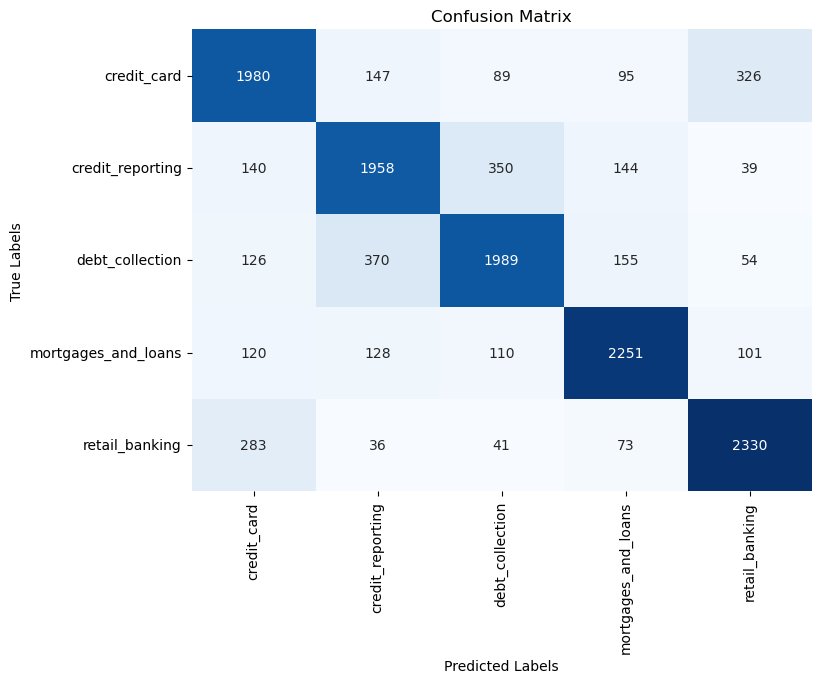

In [10]:
print("Logistic Regression Report with TF-IDF Features:")
print(report)
plot_confusion_matrix(cm)

#### 2) TF-IDF - Random Forest Classifier

In [11]:
# RF classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=WORKERS)
rf_report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, rf_model)
print("Random Forest Report with TF-IDF Features:")
print(rf_report)

Random Forest Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.78      0.78      2637
   credit_reporting       0.80      0.79      0.80      2631
    debt_collection       0.81      0.80      0.80      2694
mortgages_and_loans       0.85      0.84      0.85      2710
     retail_banking       0.83      0.84      0.83      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



##### 2.1) TF-IDF - Random Forest - Hyperparameter tuning

In [12]:
# param grid for hyperparameters
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

report, cm, model_rf = tune_and_evaluate_model(RandomForestClassifier(n_jobs=WORKERS), param_grid_rf, X_train, y_train, X_test, y_test)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   6.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   6.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   6.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   6.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=100; total time=   6.8s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  13.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  13.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  13.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   6.5s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  13.4s
[CV] END max_depth=10, min_samples_split=2, n_estimators=200; total time=  13.5s
[CV] END max_depth=10, min_samples_split=5, n_estimators=100; total time=   6.1s
[CV] END max_depth=10, min_s

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=  28.6s
[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=  28.1s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   8.3s
[CV] END max_depth=20, min_samples_split=5, n_estimators=100; total time=   8.3s
[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=  25.2s
[CV] END max_depth=20, min_samples_split=2, n_estimators=300; total time=  25.0s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  15.4s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  15.5s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  16.3s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  15.9s
[CV] END max_depth=20, min_samples_split=5, n_estimators=200; total time=  16.6s
[CV] END max_depth=20, min_samples_split=10, n_estimators=100; total time=   9.1s
[CV] END max_depth=20, min_

In [13]:
# save the model
joblib.dump(model, os.path.join("models", "rf_tfidf_model.pkl"))

['models/rf_tfidf_model.pkl']

Random Forest Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.78      0.78      0.78      2637
   credit_reporting       0.79      0.79      0.79      2631
    debt_collection       0.80      0.79      0.80      2694
mortgages_and_loans       0.85      0.84      0.85      2710
     retail_banking       0.82      0.84      0.83      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



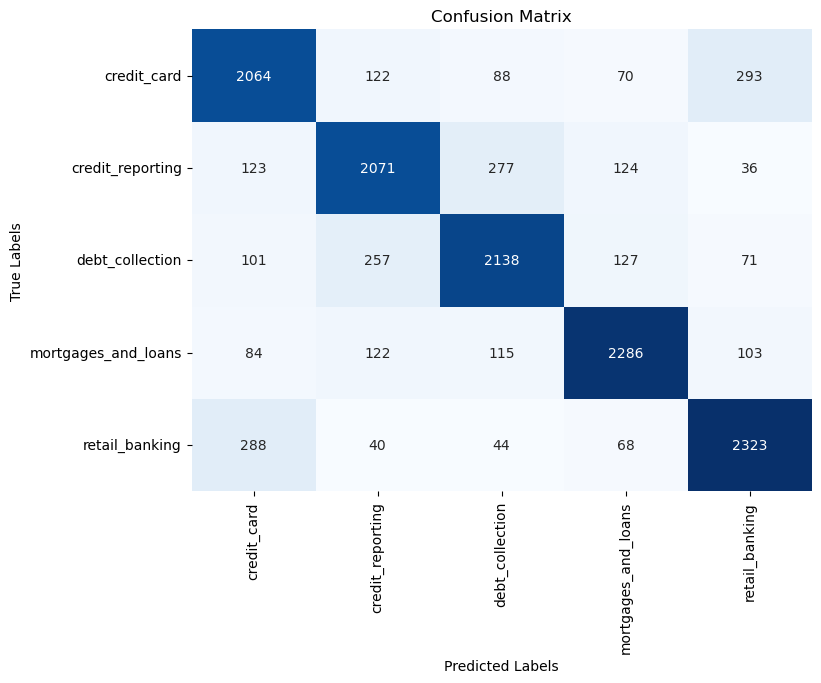

In [14]:
print("Random Forest Report with TF-IDF Features:")
print(report)
plot_confusion_matrix(cm)

#### 3) TF-IDF - XGBoost Classifier

In [15]:
# XGBoost classifier
xgb_model = XGBClassifier(eval_metric='mlogloss')
xgb_report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, xgb_model)
print("XGBoost Report with TF-IDF Features:")
print(xgb_report)

XGBoost Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.78      0.79      0.79      2637
   credit_reporting       0.79      0.79      0.79      2631
    debt_collection       0.80      0.79      0.79      2694
mortgages_and_loans       0.86      0.84      0.85      2710
     retail_banking       0.85      0.85      0.85      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



##### 3.1) TF-IDF - XGBoost - Hyperparameter tuning

In [16]:
# XGBoost Hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}
report, cm, model = tune_and_evaluate_model(xgb_model, param_grid_xgb, X_train, y_train, X_test, y_test)
joblib.dump(model, os.path.join("models", "xgb_tfidf_model.pkl"))

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=3, n_estimators=100; total time=   5.2s
[CV] END ......................max_depth=3, n_estimators=100; total time=   5.2s
[CV] END ......................max_depth=3, n_estimators=100; total time=   5.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=   5.3s
[CV] END ......................max_depth=3, n_estimators=100; total time=   5.4s


/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................max_depth=3, n_estimators=200; total time=   9.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=  10.9s
[CV] END ......................max_depth=3, n_estimators=200; total time=  11.4s
[CV] END ......................max_depth=3, n_estimators=200; total time=   9.6s
[CV] END ......................max_depth=3, n_estimators=200; total time=   9.6s
[CV] END ......................max_depth=3, n_estimators=300; total time=  14.3s
[CV] END ......................max_depth=4, n_estimators=100; total time=   7.2s
[CV] END ......................max_depth=4, n_estimators=100; total time=   6.6s
[CV] END ......................max_depth=4, n_estimators=100; total time=   6.9s
[CV] END ......................max_depth=3, n_estimators=300; total time=  14.7s
[CV] END ......................max_depth=3, n_estimators=300; total time=  15.3s
[CV] END ......................max_depth=3, n_estimators=300; total time=  13.9s
[CV] END ...................

['models/xgb_tfidf_model.pkl']

XGBoost Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.78      0.78      0.78      2637
   credit_reporting       0.79      0.80      0.80      2631
    debt_collection       0.80      0.80      0.80      2694
mortgages_and_loans       0.86      0.84      0.85      2710
     retail_banking       0.84      0.85      0.85      2763

           accuracy                           0.82     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.82      0.82      0.82     13435



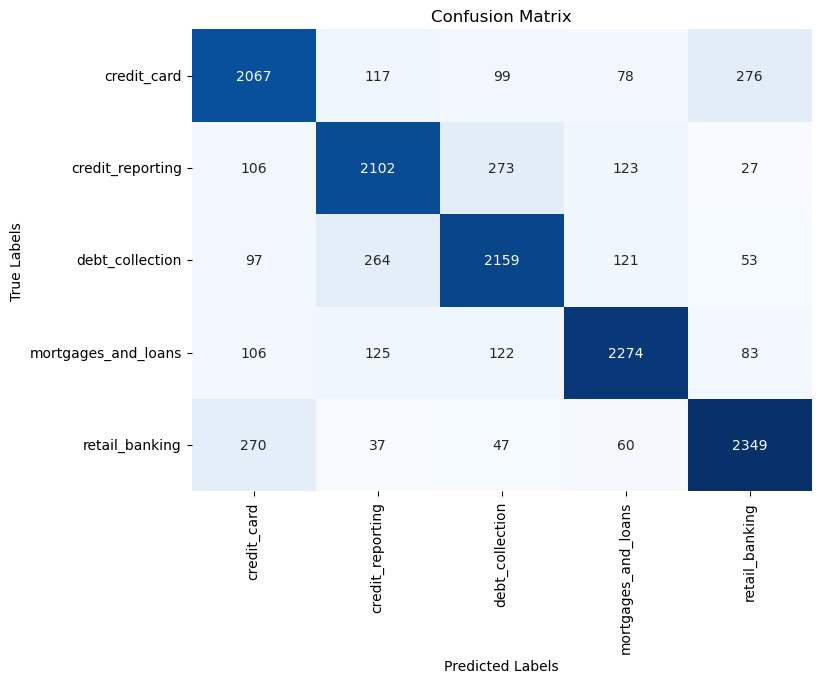

In [17]:
print("XGBoost Report with TF-IDF Features:")
print(report)
plot_confusion_matrix(cm)


#### 4) TF-IDF - Naive Bayes Classifier

In [18]:
# Naive Bayes Classifier
nb_model = MultinomialNB()
nb_report, _ = train_evaluate_model(X_train, y_train, X_test, y_test, nb_model)
print("Naive Bayes Report with TF-IDF Features:")
print(nb_report)

Naive Bayes Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.72      0.71      0.71      2637
   credit_reporting       0.71      0.74      0.73      2631
    debt_collection       0.75      0.67      0.71      2694
mortgages_and_loans       0.79      0.84      0.81      2710
     retail_banking       0.81      0.83      0.82      2763

           accuracy                           0.76     13435
          macro avg       0.76      0.76      0.76     13435
       weighted avg       0.76      0.76      0.76     13435



##### 4.1) TF-IDF - Naive Bayes - Hyperparameter tuning

In [19]:
# Naiva Bayes Hyperparameter tuning
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0]
}
report, cm, model = tune_and_evaluate_model(nb_model, param_grid_nb, X_train, y_train, X_test, y_test)  
joblib.dump(model, os.path.join("models", "nb_tfidf_model.pkl"))


Fitting 5 folds for each of 3 candidates, totalling 15 fits


[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=0.5; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ..........................................alpha=1.0; total time=   0.0s
[CV] END ...................

['models/nb_tfidf_model.pkl']

Naive Bayes Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.72      0.71      0.71      2637
   credit_reporting       0.71      0.74      0.73      2631
    debt_collection       0.75      0.67      0.71      2694
mortgages_and_loans       0.79      0.84      0.81      2710
     retail_banking       0.81      0.83      0.82      2763

           accuracy                           0.76     13435
          macro avg       0.76      0.76      0.76     13435
       weighted avg       0.76      0.76      0.76     13435



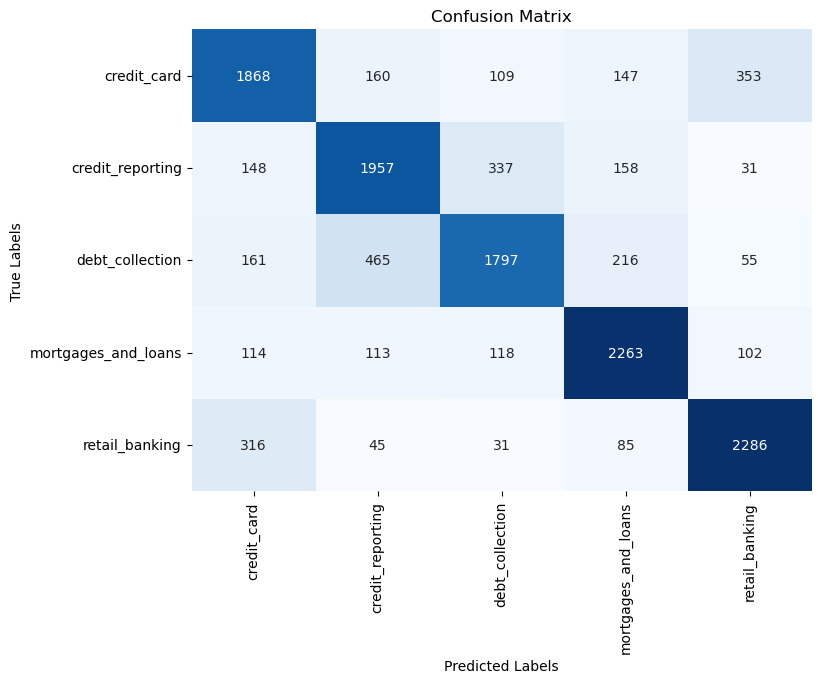

In [20]:
print("Naive Bayes Report with TF-IDF Features:")
print(report)
plot_confusion_matrix(cm)

#### 5) TF-IDF - Support Vector Machine Classifier

To speed up things, we first train a linear SVM model and then a non-linear one (without extensive hyperparameter tuning).

In [21]:
# train a linear SVM model first with LinearSVC
svm_model = LinearSVC()
svm_report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, svm_model)
print("Linear SVM Report with TF-IDF Features:")
print(svm_report)

Linear SVM Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.75      0.76      0.75      2637
   credit_reporting       0.73      0.75      0.74      2631
    debt_collection       0.79      0.72      0.75      2694
mortgages_and_loans       0.83      0.83      0.83      2710
     retail_banking       0.81      0.85      0.83      2763

           accuracy                           0.78     13435
          macro avg       0.78      0.78      0.78     13435
       weighted avg       0.78      0.78      0.78     13435



In [22]:
# tune it 
param_grid_svm = {
    'C': [0.1, 1, 10, 15]
}

report, cm, model = tune_and_evaluate_model(svm_model, param_grid_svm, X_train, y_train, X_test, y_test)
joblib.dump(model, os.path.join("models", "svm_lin_tfidf_model.pkl"))

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.1; total time=   1.4s
[CV] END ..............................................C=0.1; total time=   1.5s
[CV] END ..............................................C=0.1; total time=   1.5s
[CV] END ..............................................C=0.1; total time=   1.5s
[CV] END ..............................................C=0.1; total time=   1.6s
[CV] END ................................................C=1; total time=   1.7s
[CV] END ................................................C=1; total time=   1.7s
[CV] END ................................................C=1; total time=   1.8s
[CV] END ................................................C=1; total time=   1.8s
[CV] END ................................................C=1; total time=   1.8s
[CV] END ...............................................C=10; total time=   1.8s
[CV] END ........................................

['models/svm_lin_tfidf_model.pkl']

In [23]:
# support vector machine with rbf kernel
svm_model = SVC(max_iter=100, kernel='rbf', gamma='auto', cache_size=4096) # stop early to get faster convergence
# use linearsvc
svm_model = LinearSVC()
report, _ = train_evaluate_model(X_train, y_train, X_test, y_test, svm_model)
print("SVM Report with TF-IDF Features:")
print(report)

SVM Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.75      0.76      0.75      2637
   credit_reporting       0.73      0.75      0.74      2631
    debt_collection       0.79      0.72      0.75      2694
mortgages_and_loans       0.83      0.83      0.83      2710
     retail_banking       0.81      0.85      0.83      2763

           accuracy                           0.78     13435
          macro avg       0.78      0.78      0.78     13435
       weighted avg       0.78      0.78      0.78     13435



SVM Report with TF-IDF Features:
                     precision    recall  f1-score   support

        credit_card       0.75      0.76      0.75      2637
   credit_reporting       0.72      0.76      0.74      2631
    debt_collection       0.79      0.72      0.75      2694
mortgages_and_loans       0.84      0.83      0.83      2710
     retail_banking       0.82      0.85      0.84      2763

           accuracy                           0.78     13435
          macro avg       0.78      0.78      0.78     13435
       weighted avg       0.78      0.78      0.78     13435



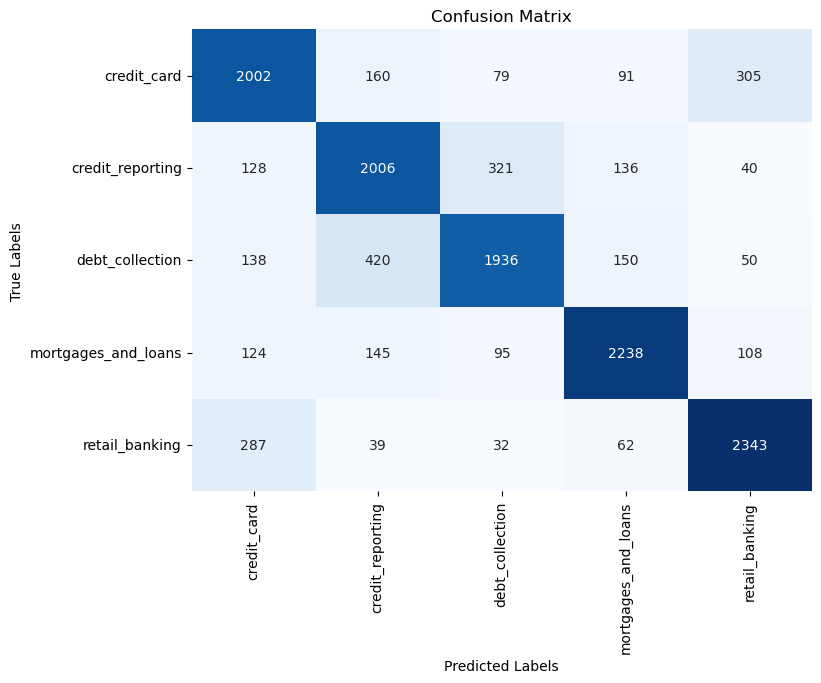

['models/svm_rbf_tfidf_model.pkl']

In [24]:
# train one non-linear SVM model with rbf kernel and higher regularization without early stopping
svm_model = SVC(kernel='rbf', gamma='auto', C=10, cache_size=4096) # set cache size depending on available memory
report, cm = train_evaluate_model(X_train, y_train, X_test, y_test, svm_model)

print("SVM Report with TF-IDF Features:")
print(report)
plot_confusion_matrix(cm)

# save the model
joblib.dump(svm_model, os.path.join("models", "svm_rbf_tfidf_model.pkl"))

#### 6) Word2Vec - Logistic regression

In [25]:
# train lr model
lr_model_w2v = LogisticRegression(max_iter=1000)
lr_report_w2v, _ = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, lr_model_w2v)
print("Logistic Regression Report with Word2Vec Features:")
print(lr_report_w2v)

Logistic Regression Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.80      0.79      2637
   credit_reporting       0.79      0.77      0.78      2631
    debt_collection       0.81      0.78      0.79      2694
mortgages_and_loans       0.85      0.86      0.86      2710
     retail_banking       0.84      0.86      0.85      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



##### 6.1) Word2Vec - Logistic regression - Hyperparameter tuning

In [26]:
# Define the parameter grid for Logistic Regression
param_grid_lr = {'C': [0.1, 1, 10, 100], 'solver': ['lbfgs', 'liblinear']}

report, cm, model = tune_and_evaluate_model(lr_model_w2v, param_grid_lr, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
joblib.dump(model, os.path.join("models", "lr_w2v_model.pkl"))


Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.1s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.2s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.3s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.4s
[CV] END ................................C=0.1, solver=lbfgs; total time=   2.4s


/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..................................C=1, solver=lbfgs; total time=   3.2s
[CV] END ..................................C=1, solver=lbfgs; total time=   3.1s
[CV] END ..................................C=1, solver=lbfgs; total time=   3.4s
[CV] END ..................................C=1, solver=lbfgs; total time=   3.1s
[CV] END ..................................C=1, solver=lbfgs; total time=   2.5s
[CV] END ............................C=0.1, solver=liblinear; total time=  15.2s
[CV] END ............................C=0.1, solver=liblinear; total time=  16.0s
[CV] END ............................C=0.1, solver=liblinear; total time=  16.6s
[CV] END ............................C=0.1, solver=liblinear; total time=  16.7s
[CV] END ............................C=0.1, solver=liblinear; total time=  16.6s
[CV] END .................................C=10, solver=lbfgs; total time=   3.7s
[CV] END .................................C=10, solver=lbfgs; total time=   3.4s
[CV] END ...................

['models/lr_w2v_model.pkl']

Logistic Regression Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.80      0.79      2637
   credit_reporting       0.79      0.77      0.78      2631
    debt_collection       0.81      0.78      0.79      2694
mortgages_and_loans       0.85      0.86      0.86      2710
     retail_banking       0.84      0.86      0.85      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



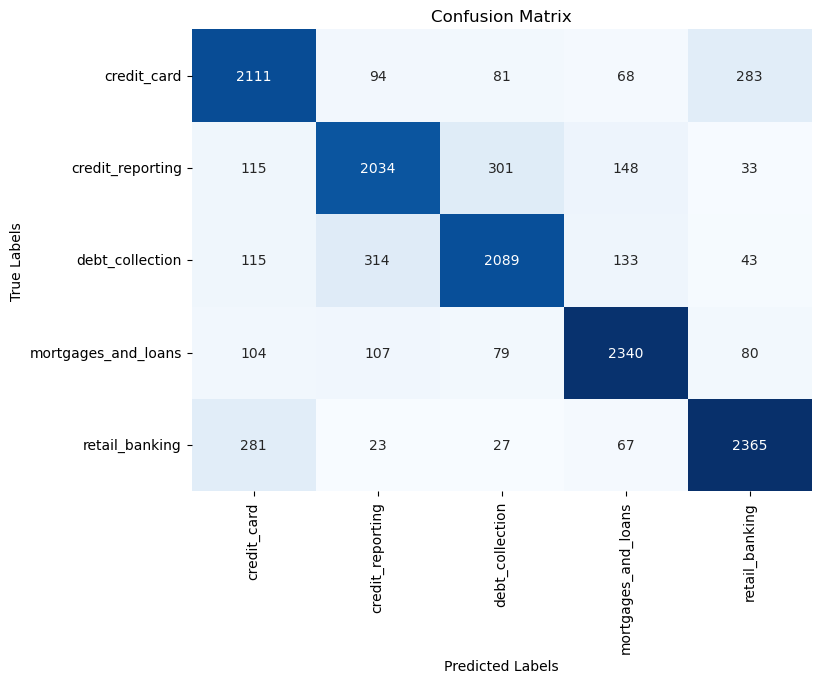

In [27]:
print("Logistic Regression Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

#### 7) Word2Vec - Random Forest classifier

In [28]:
# train rf model
rf_model_w2v = RandomForestClassifier(n_estimators=100, random_state=10, n_jobs=-1)

rf_report_w2v, _ = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, rf_model_w2v)
print("Random Forest Report with Word2Vec Features:")
print(rf_report_w2v)

Random Forest Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.77      0.76      0.76      2637
   credit_reporting       0.80      0.82      0.81      2631
    debt_collection       0.83      0.78      0.81      2694
mortgages_and_loans       0.84      0.85      0.84      2710
     retail_banking       0.83      0.86      0.84      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



##### 7.1) Word2Vec - Random Forest - Hyperparameter tuning

In [29]:
# tune rf model
param_grid_rf = {
    'n_estimators': [200, 300],
    'max_depth': [20, 30],
    'min_samples_split': [2, 5],
    'n_jobs': [-1]
}

report, cm, model = tune_and_evaluate_model(RandomForestClassifier(warm_start=True, n_jobs=WORKERS), # warm start and parallel for faster training
                                            param_grid_rf, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
joblib.dump(model, os.path.join("models", "rf_w2v_model.pkl"))

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV] END max_depth=20, min_samples_split=2, n_estimators=200, n_jobs=-1; total time= 1.6min
[CV] END max_depth=20, min_samples_split=2, n_estimators=200, n_jobs=-1; total time= 1.6min


/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END max_depth=20, min_samples_split=2, n_estimators=200, n_jobs=-1; total time= 1.7min
[CV] END max_depth=20, min_samples_split=2, n_estimators=200, n_jobs=-1; total time= 1.7min
[CV] END max_depth=20, min_samples_split=2, n_estimators=200, n_jobs=-1; total time= 1.7min
[CV] END max_depth=20, min_samples_split=2, n_estimators=300, n_jobs=-1; total time= 2.3min
[CV] END max_depth=20, min_samples_split=2, n_estimators=300, n_jobs=-1; total time= 2.4min
[CV] END max_depth=20, min_samples_split=2, n_estimators=300, n_jobs=-1; total time= 2.4min
[CV] END max_depth=20, min_samples_split=5, n_estimators=200, n_jobs=-1; total time= 1.5min
[CV] END max_depth=20, min_samples_split=5, n_estimators=200, n_jobs=-1; total time= 1.5min
[CV] END max_depth=20, min_samples_split=5, n_estimators=200, n_jobs=-1; total time= 1.5min
[CV] END max_depth=20, min_samples_split=2, n_estimators=300, n_jobs=-1; total time= 2.2min
[CV] END max_depth=20, min_samples_split=2, n_estimators=300, n_jobs=-1; total t

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/sklearn/ensemble/_forest.py:468: UserWarning: Warm-start fitting without increasing n_estimators does not fit new trees.
  warn(


['models/rf_w2v_model.pkl']

Random Forest Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.78      0.77      0.77      2637
   credit_reporting       0.81      0.83      0.82      2631
    debt_collection       0.83      0.80      0.81      2694
mortgages_and_loans       0.84      0.85      0.85      2710
     retail_banking       0.84      0.86      0.85      2763

           accuracy                           0.82     13435
          macro avg       0.82      0.82      0.82     13435
       weighted avg       0.82      0.82      0.82     13435



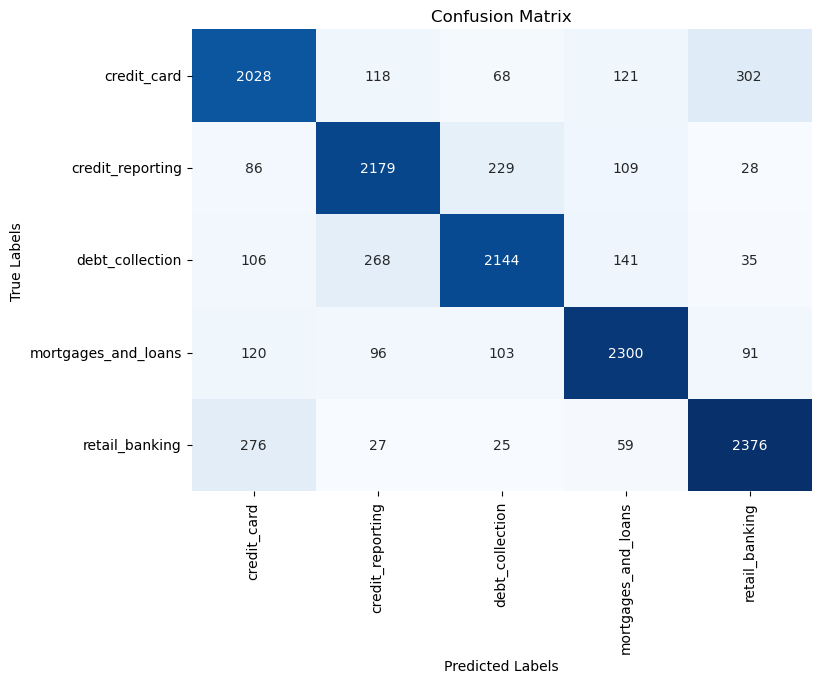

In [30]:
print("Random Forest Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

#### 8) Word2Vec - XGBoost Classifier

In [31]:
# train xgb model
xgb_model_w2v = XGBClassifier(eval_metric='mlogloss')
xgb_report_w2v, _ = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, xgb_model_w2v)
print("XGBoost Report with Word2Vec Features:")
print(xgb_report_w2v)

XGBoost Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.79      0.80      0.79      2637
   credit_reporting       0.82      0.83      0.82      2631
    debt_collection       0.83      0.81      0.82      2694
mortgages_and_loans       0.86      0.86      0.86      2710
     retail_banking       0.86      0.86      0.86      2763

           accuracy                           0.83     13435
          macro avg       0.83      0.83      0.83     13435
       weighted avg       0.83      0.83      0.83     13435



##### 8.1) Word2Vec - XGBoost - Hyperparameter tuning

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=3, n_estimators=100; total time=   9.1s
[CV] END ......................max_depth=3, n_estimators=100; total time=   9.1s
[CV] END ......................max_depth=3, n_estimators=100; total time=   9.1s
[CV] END ......................max_depth=3, n_estimators=100; total time=   9.1s
[CV] END ......................max_depth=3, n_estimators=100; total time=   9.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=  16.9s
[CV] END ......................max_depth=3, n_estimators=200; total time=  17.3s
[CV] END ......................max_depth=3, n_estimators=200; total time=  17.4s
[CV] END ......................max_depth=3, n_estimators=200; total time=  17.4s
[CV] END ......................max_depth=3, n_estimators=200; total time=  17.8s
[CV] END ......................max_depth=4, n_estimators=100; total time=  12.3s
[CV] END ......................max_depth=3, n_est

/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ......................max_depth=5, n_estimators=100; total time=  17.5s
[CV] END ......................max_depth=4, n_estimators=300; total time=  35.7s
[CV] END ......................max_depth=5, n_estimators=200; total time=  30.8s
[CV] END ......................max_depth=5, n_estimators=200; total time=  32.0s
[CV] END ......................max_depth=5, n_estimators=200; total time=  31.9s
[CV] END ......................max_depth=5, n_estimators=200; total time=  32.1s
[CV] END ......................max_depth=5, n_estimators=200; total time=  31.1s
[CV] END ......................max_depth=5, n_estimators=300; total time=  44.4s
[CV] END ......................max_depth=5, n_estimators=300; total time=  45.0s
[CV] END ......................max_depth=5, n_estimators=300; total time=  44.9s
[CV] END ......................max_depth=5, n_estimators=300; total time=  42.9s
[CV] END ......................max_depth=5, n_estimators=300; total time=  42.2s
Best hyperparameters:  {'max

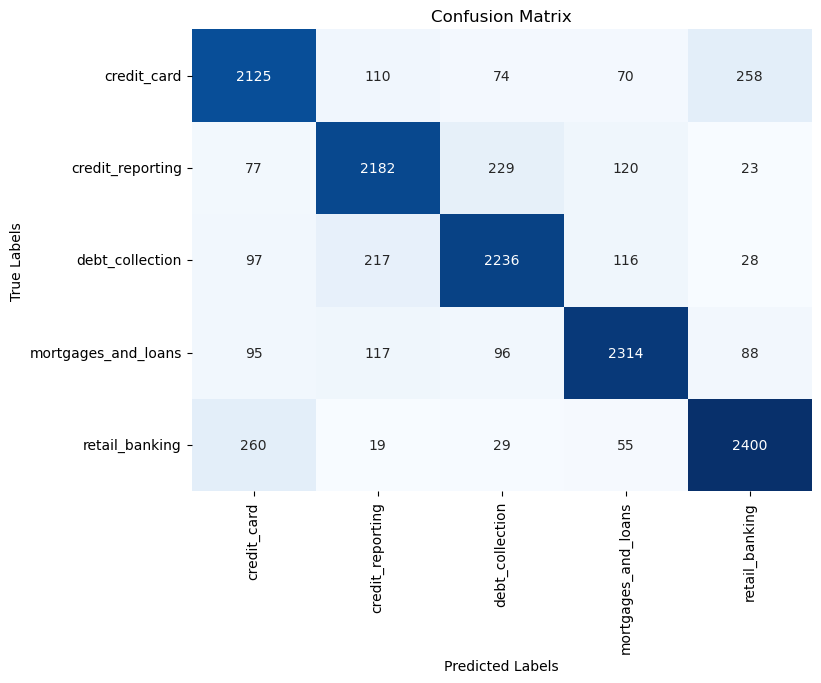

In [32]:
# XGBoost Hyperparameter tuning
param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5]
}

report, cm, model = tune_and_evaluate_model(xgb_model_w2v, param_grid_xgb, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
joblib.dump(model, os.path.join("models", "xgb_w2v_model.pkl"))

print("XGBoost Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

#### 9) Word2Vec - Naive Bayes Classifier

In [33]:
### MultinomialNB cannot handle negative values
### switch to GaussianNB
### alternatively, we could scale the data, but not sure if that is a good idea

nb_model_w2v = GaussianNB()
nb_report_w2v, _ = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, nb_model_w2v)
print("Naive Bayes Report with Word2Vec Features:")
print(nb_report_w2v)

Naive Bayes Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.65      0.59      0.62      2637
   credit_reporting       0.69      0.72      0.71      2631
    debt_collection       0.73      0.57      0.64      2694
mortgages_and_loans       0.70      0.83      0.76      2710
     retail_banking       0.76      0.81      0.78      2763

           accuracy                           0.71     13435
          macro avg       0.70      0.70      0.70     13435
       weighted avg       0.71      0.71      0.70     13435



##### 9.1) Word2Vec - Naive Bayes - Hyperparameter tuning

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-09; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-08; total time=   0.1s
[CV] END ................................var_smoothing=1e-07; total time=   0.1s
[CV] END ................................var_smoo

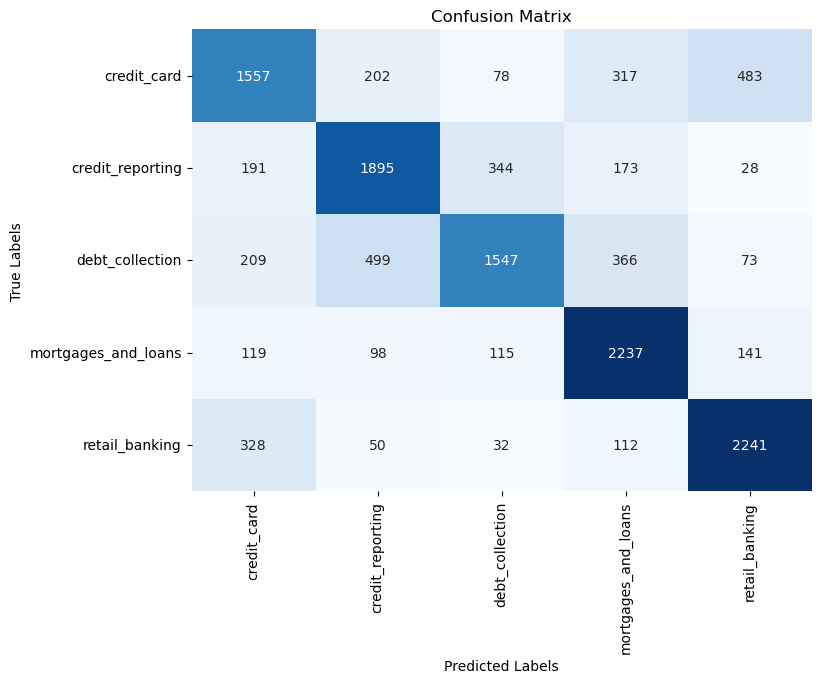

In [34]:
# Naiva Bayes Hyperparameter tuning
param_grid_nb = {
    'var_smoothing': [1e-09, 1e-08, 1e-07]
}

report, cm, model = tune_and_evaluate_model(nb_model_w2v, param_grid_nb, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
joblib.dump(model, os.path.join("models", "nb_w2v_model.pkl"))

print("Naive Bayes Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

#### 10) Word2Vec - Support Vector Machine Classifier

In [35]:
# train a linear SVM model first with LinearSVC
svm_model_w2v = LinearSVC()
svm_report_w2v, _ = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, svm_model_w2v)
print("Linear SVM Report with Word2Vec Features:")
print(svm_report_w2v)


Linear SVM Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.78      0.79      0.78      2637
   credit_reporting       0.79      0.76      0.78      2631
    debt_collection       0.82      0.77      0.79      2694
mortgages_and_loans       0.84      0.87      0.85      2710
     retail_banking       0.83      0.87      0.85      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



##### 10.1) Word2Vec - SVM - Hyperparameter tuning

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] END ..............................................C=0.1; total time=  12.9s
[CV] END ..............................................C=0.1; total time=  12.9s


/Users/michaela/anaconda3/envs/nlp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV] END ..............................................C=0.1; total time=  13.2s
[CV] END ..............................................C=0.1; total time=  13.1s
[CV] END ..............................................C=0.1; total time=  13.3s
[CV] END ................................................C=1; total time=  13.4s
[CV] END ................................................C=1; total time=  13.9s
[CV] END ................................................C=1; total time=  14.5s
[CV] END ................................................C=1; total time=  13.2s
[CV] END ...............................................C=10; total time=  13.1s
[CV] END ...............................................C=10; total time=  13.1s
[CV] END ...............................................C=10; total time=  13.5s
[CV] END ................................................C=1; total time=  14.0s
[CV] END ...............................................C=10; total time=  13.2s
[CV] END ...................

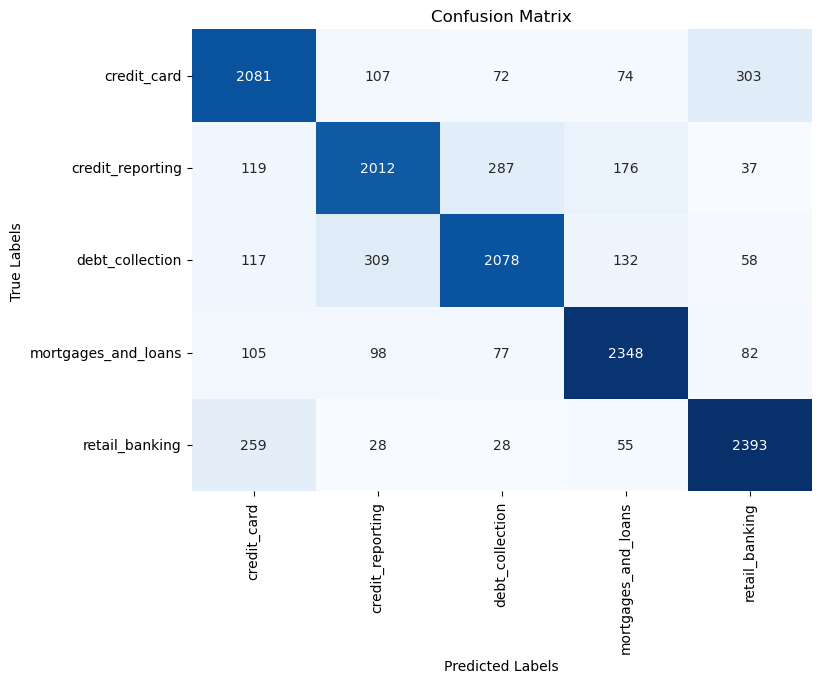

In [36]:
# tune the linear model 
param_grid_svm = {
    'C': [0.1, 1, 10, 15]
}

report, cm, model = tune_and_evaluate_model(svm_model_w2v, param_grid_svm, X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v)
joblib.dump(model, os.path.join("models", "svm_lin_w2v_model.pkl"))

print("Linear SVM Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

SVM Report with Word2Vec Features:
                     precision    recall  f1-score   support

        credit_card       0.80      0.82      0.81      2637
   credit_reporting       0.81      0.82      0.82      2631
    debt_collection       0.84      0.82      0.83      2694
mortgages_and_loans       0.88      0.86      0.87      2710
     retail_banking       0.87      0.87      0.87      2763

           accuracy                           0.84     13435
          macro avg       0.84      0.84      0.84     13435
       weighted avg       0.84      0.84      0.84     13435



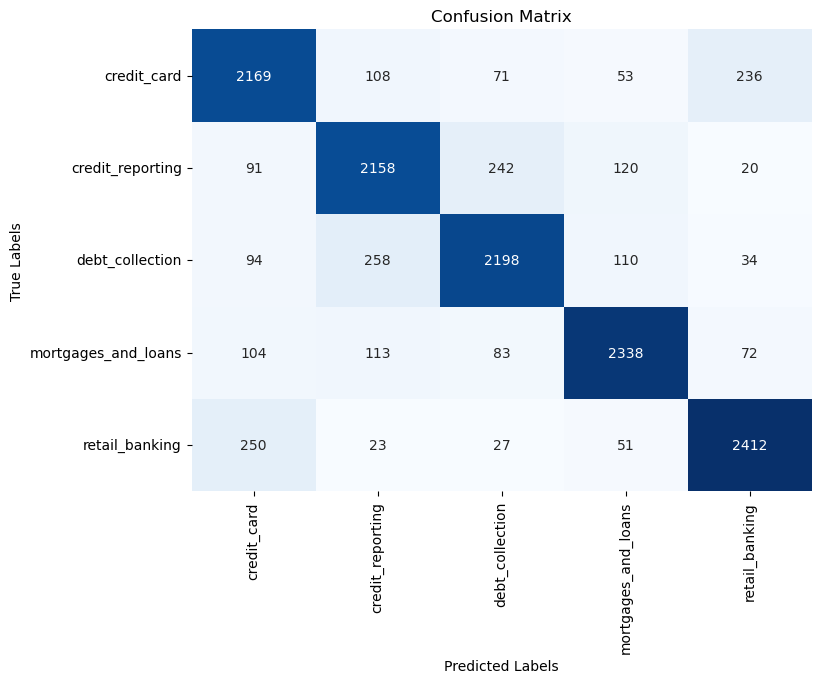

['models/svm_rbf_w2v_model.pkl']

In [37]:
# train one non-linear SVM model with rbf kernel and C=0.1 without early stopping
svm_model_w2v = SVC(kernel='rbf', C=1, cache_size=4096)
report, cm = train_evaluate_model(X_train_w2v, y_train_w2v, X_test_w2v, y_test_w2v, svm_model_w2v)

print("SVM Report with Word2Vec Features:")
print(report)
plot_confusion_matrix(cm)

# save the model
joblib.dump(svm_model_w2v, os.path.join("models", "svm_rbf_w2v_model.pkl"))

### Neural Networks

In [38]:
## use gpu if available
# use cuda if available or use mps on mac or cpu
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

Using device: mps


In [39]:
# class definitions

In [40]:
## neural network

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 128)  # input layer
        self.fc2 = nn.Linear(128, 64)           # hidden layer
        self.fc3 = nn.Linear(64, num_classes)   # output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def fit(self, train_loader, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            self.train()  # set model to training mode
            for inputs, labels in train_loader:
                # move inputs and labels to device
                inputs, labels = inputs.to(device), labels.to(device)

                # set gradients to zero
                optimizer.zero_grad()
                # forward pass
                outputs = self(inputs)
                # calculate loss
                loss = criterion(outputs, labels)
                # backward pass
                loss.backward()
                # update weights
                optimizer.step()

            # print loss after every epoch
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item()}")

    def evaluate(self, X, y, target_names=None):
        self.eval()  # set to evaluation mode
        with torch.no_grad():  # disable gradient computation
            y_pred = self(X.to(device))  # move inputs to device and get predictions
            _, predicted = torch.max(y_pred, 1) # get the class with highest probability
            
            # move back to cpu for evaluation
            predicted = predicted.cpu().numpy()
            y = y.cpu().numpy()  

            print("Accuracy:", accuracy_score(y, predicted))
            print(classification_report(y, predicted, target_names=target_names))
            plot_confusion_matrix(confusion_matrix(y, predicted), target_names)

    def save(self, path):
        torch.save(self.state_dict(), path)
    
    def load(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()

In [41]:
## convolutional neural network
# (inital idea was for all classes to inherit from NeuralNetwork, but it was a bit too much for this task and hard to debug
# so they were kept separate and just have their own evaluate, save, load method)

class Convolution(NeuralNetwork):
    def __init__(self, input_size, num_classes):
        super(Convolution, self).__init__(input_size, num_classes)  

        # 2 1d convolutional layers
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, stride=1)
        self.conv2 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1)
        
        # max-pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # calculate the flattened size for the fully connected layer
        self.flattened_size = self._get_flattened_size(input_size)
        
        # fully connected layers
        self.fc1 = nn.Linear(self.flattened_size, 128)
        self.fc2 = nn.Linear(128, num_classes)  # number of classes

    def _get_flattened_size(self, input_size):
        # create a dummy input to calculate the size after convolutions and pooling
        x = torch.randn(1, 1, input_size)  # shape (batch_size, channels, sequence_length)
        x = self.pool(torch.relu(self.conv1(x))) # pass through first convolution and pooling
        x = self.pool(torch.relu(self.conv2(x))) # pass through second convolution and pooling
        flattened_size = x.view(1, -1).size(1) # flatten the tensor
        return flattened_size

    def forward(self, x):
        # pass through first convolution and pooling
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
    
        # pass through second convolution and pooling
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
    
        # flatten the tensor for fully connected layers
        x = x.view(x.size(0), -1)  # flatten
    
        # fully connected layers
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)  # output logits (no activation here, softmax/crossentropy later)
        return x
    
    def evaluate(self, data_loader, target_names=None):
        self.eval()  # set the model to evaluation mode
        all_preds = []  
        all_labels = []  

        with torch.no_grad():  # disable gradient computation
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # move to device
                y_pred = self(inputs)  # forward pass to get predictions
                _, predicted = torch.max(y_pred, 1)  # get predicted class with highest probability

                # store predictions and labels
                all_preds.append(predicted.cpu().numpy())  # move predictions to cpu and convert to numpy
                all_labels.append(labels.cpu().numpy())    # move labels to cpu and convert to numpy

        # concatenate all predictions and labels
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        # evaluate and print metrics
        print("Accuracy:", accuracy_score(all_labels, all_preds))
        print(classification_report(all_labels, all_preds, target_names=target_names))
        plot_confusion_matrix(confusion_matrix(all_labels, all_preds), target_names)


In [42]:
## recurrent neural network
class Recurrent(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(Recurrent, self).__init__()
        # rnn layer
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        # fully connected layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # pass through rnn
        out, _ = self.rnn(x)  # shape: (batch_size, seq_length, hidden_size)
        # get the last output
        out = out[:, -1, :]    # shape: (batch_size, hidden_size)
        # pass through fully connected layer
        out = self.fc(out)     # shape: (batch_size, num_classes)
        return out
    
    def fit(self, train_loader, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            self.train()
            for inputs, labels in train_loader:
                # move inputs and labels to device
                inputs, labels = inputs.to(device), labels.to(device)
                # set gradients to zero
                optimizer.zero_grad()
                # forward pass to get predictions
                outputs = self(inputs)
                # calculate loss
                loss = criterion(outputs, labels)
                # backward pass
                loss.backward()
                # update weights
                optimizer.step()
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item()}")


    def evaluate(self, data_loader, target_names=None):
        self.eval()  # set the model to evaluation mode
        all_preds = []  # to store predictions
        all_labels = []  # to store true labels

        with torch.no_grad():  # disable gradient computation
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # move to device
                y_pred = self(inputs)  # forward pass
                _, predicted = torch.max(y_pred, 1)  # get predicted class

                # store predictions and labels
                all_preds.append(predicted.cpu().numpy())  # move predictions to cpu and convert to numpy
                all_labels.append(labels.cpu().numpy())    # move labels to cpu and convert to numpy

        # concatenate all predictions and labels
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        # evaluate and print metrics
        print("Accuracy:", accuracy_score(all_labels, all_preds))
        print(classification_report(all_labels, all_preds, target_names=target_names))
        plot_confusion_matrix(confusion_matrix(all_labels, all_preds), target_names)

    def save(self, path):
            torch.save(self.state_dict(), path)

    def load(self, path):
            self.load_state_dict(torch.load(path))
            self.eval()



In [43]:
## bidirectional lstm

class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(BiLSTM, self).__init__()
        # bi-directional LSTM layer
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, 
                            batch_first=True, bidirectional=True)
        
        # fully connected layer
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # multiply hidden_size by 2 for bidirectional

    def forward(self, x):
        # pass through LSTM
        out, _ = self.lstm(x)  # Shape: (batch_size, seq_length, hidden_size * 2)
        # get the last output
        out = out[:, -1, :]  # Shape: (batch_size, hidden_size * 2)
        # pass through fully connected layer
        out = self.fc(out)  # Shape: (batch_size, num_classes)
        return out

    def fit(self, train_loader, epochs=10, lr=0.001):
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self.parameters(), lr=lr)

        for epoch in range(epochs):
            self.train()
            for inputs, labels in train_loader:
                # move inputs and labels to device
                inputs, labels = inputs.to(device), labels.to(device)
                # set gradients to zero
                optimizer.zero_grad()
                # forward pass to get predictions
                outputs = self(inputs)
                # calculate loss
                loss = criterion(outputs, labels)
                # backward pass
                loss.backward()
                # update weights
                optimizer.step()
            print(f"Epoch {epoch + 1}/{epochs} - Loss: {loss.item()}")

    def evaluate(self, data_loader, target_names=None):
        self.eval()  # set the model to evaluation mode
        all_preds = []  
        all_labels = []  

        with torch.no_grad():  # disable gradient computation
            for inputs, labels in data_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # move to device
                # forward pass to get predictions
                y_pred = self(inputs) 
                # get the class with highest probability
                _, predicted = torch.max(y_pred, 1)  # Get predicted class

                # store predictions and labels
                all_preds.append(predicted.cpu().numpy())  # Move predictions to CPU and convert to numpy
                all_labels.append(labels.cpu().numpy())    # Move labels to CPU and convert to numpy

        # concatenate all predictions and labels
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)

        # evaluate and print metrics
        print("Accuracy:", accuracy_score(all_labels, all_preds))
        print(classification_report(all_labels, all_preds, target_names=target_names))
        plot_confusion_matrix(confusion_matrix(all_labels, all_preds), target_names)
    
    def save(self, path):
        torch.save(self.state_dict(), path)
    

    def load(self, path):
        self.load_state_dict(torch.load(path))
        self.eval()

    



#### Multilayer NN

##### TFIDF

In [44]:
# prepare tensors of TF-IDF embeddings and move to device
X_train_tensor = torch.tensor(X_train.values).float().to(device)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_test_tensor = torch.tensor(X_test.values).float().to(device)
y_test_tensor = torch.tensor(y_test).long().to(device)

# create a data loader
batch_size = 128 
train_dataset_tfidf = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_tfidf = DataLoader(train_dataset_tfidf, batch_size=batch_size, shuffle=True)

# train the model
num_classes = len(np.unique(y_train))  
model_nn = NeuralNetwork(input_size=X_train_tensor.shape[1], num_classes=num_classes).to(device)
model_nn.fit(train_loader_tfidf, epochs=10, lr=0.001)


Epoch 1/10 - Loss: 0.5802801251411438
Epoch 2/10 - Loss: 0.5808357000350952
Epoch 3/10 - Loss: 0.694583535194397
Epoch 4/10 - Loss: 0.6820067167282104
Epoch 5/10 - Loss: 0.5533919930458069
Epoch 6/10 - Loss: 0.45752960443496704
Epoch 7/10 - Loss: 0.606336236000061
Epoch 8/10 - Loss: 0.5821067094802856
Epoch 9/10 - Loss: 0.3809162378311157
Epoch 10/10 - Loss: 0.5550857186317444


Neural Network Report with TFIDF Features:
Accuracy: 0.8071455154447339
                     precision    recall  f1-score   support

        credit_card       0.77      0.79      0.78      2637
   credit_reporting       0.80      0.75      0.77      2631
    debt_collection       0.78      0.80      0.79      2694
mortgages_and_loans       0.85      0.84      0.85      2710
     retail_banking       0.84      0.86      0.85      2763

           accuracy                           0.81     13435
          macro avg       0.81      0.81      0.81     13435
       weighted avg       0.81      0.81      0.81     13435



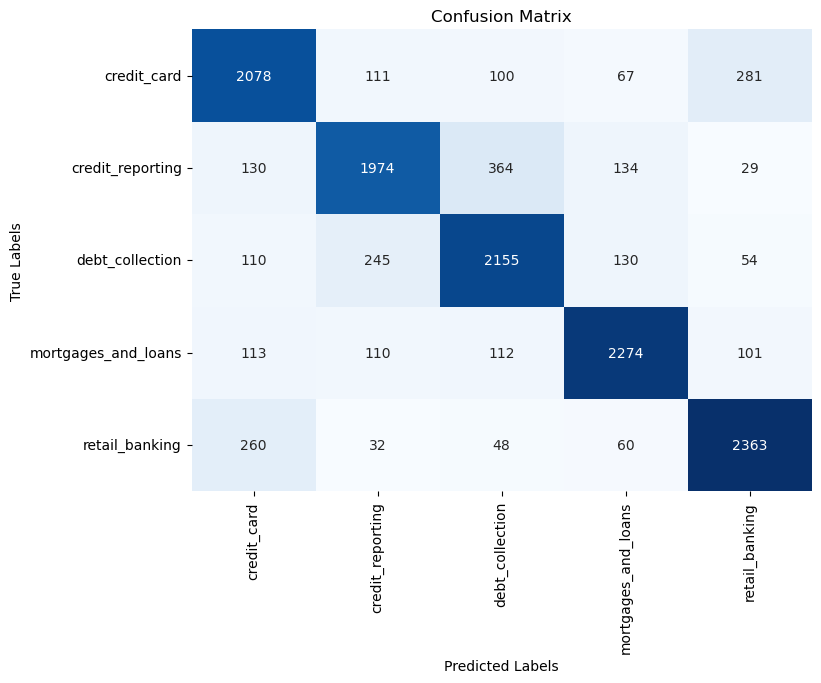

In [45]:
# Evaluate the model
print("Neural Network Report with TFIDF Features:")
model_nn.evaluate(X_test_tensor, y_test_tensor, target_names=le.classes_)  

##### Word2Vec

In [46]:
# prepare tensors of word2vec embeddings and move to device
X_train_tensor_w2v = torch.tensor(X_train_w2v.values).float().to(device)
y_train_tensor_w2v = torch.tensor(y_train_w2v).long().to(device)
X_test_tensor_w2v = torch.tensor(X_test_w2v.values).float().to(device)
y_test_tensor_w2v = torch.tensor(y_test_w2v).long().to(device)

# create a data loader
train_dataset_w2v = TensorDataset(X_train_tensor_w2v, y_train_tensor_w2v)
train_loader_w2v = DataLoader(train_dataset_w2v, batch_size=batch_size, shuffle=True)

# train the model
model_nn_w2v = NeuralNetwork(input_size=X_train_tensor_w2v.shape[1], num_classes=num_classes).to(device)
model_nn_w2v.fit(train_loader_w2v, epochs=10, lr=0.001)

Epoch 1/10 - Loss: 0.47286033630371094
Epoch 2/10 - Loss: 0.6928231120109558
Epoch 3/10 - Loss: 0.44039902091026306
Epoch 4/10 - Loss: 0.5360976457595825
Epoch 5/10 - Loss: 0.5531163811683655
Epoch 6/10 - Loss: 0.3427715301513672
Epoch 7/10 - Loss: 0.36404380202293396
Epoch 8/10 - Loss: 0.4668837785720825
Epoch 9/10 - Loss: 0.44532719254493713
Epoch 10/10 - Loss: 0.34810519218444824


Neural Network Report with Word2Vec Features:
Accuracy: 0.8395236323036844
                     precision    recall  f1-score   support

        credit_card       0.82      0.81      0.81      2637
   credit_reporting       0.83      0.80      0.81      2631
    debt_collection       0.82      0.83      0.82      2694
mortgages_and_loans       0.87      0.87      0.87      2710
     retail_banking       0.85      0.90      0.87      2763

           accuracy                           0.84     13435
          macro avg       0.84      0.84      0.84     13435
       weighted avg       0.84      0.84      0.84     13435



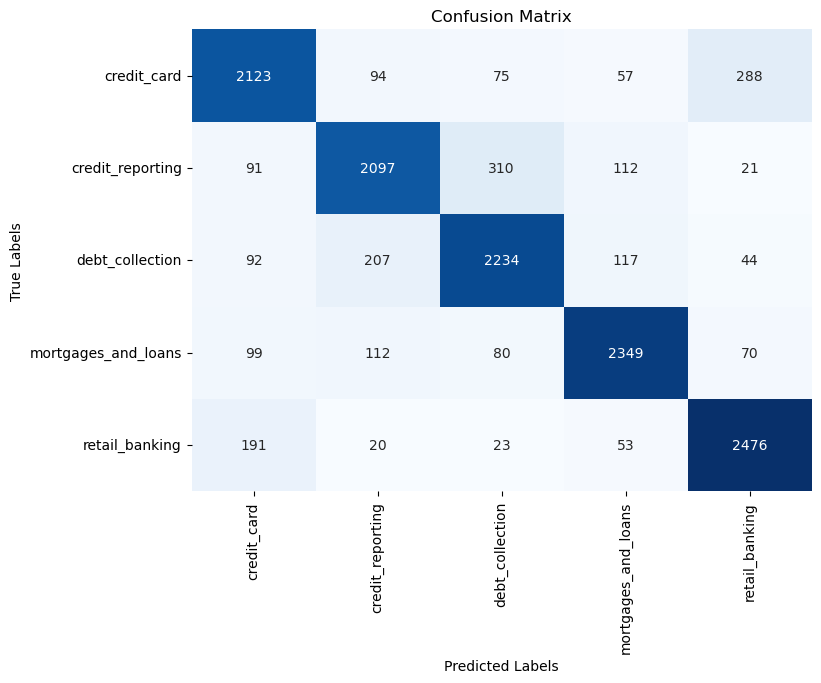

In [47]:
# evaluate the model
print("Neural Network Report with Word2Vec Features:")
model_nn_w2v.evaluate(X_test_tensor_w2v, y_test_tensor_w2v, target_names=le.classes_)
# Save the model
model_nn_w2v.save(os.path.join("models", "nn_w2v_model.pth"))

#### Convolutional Neural Network

##### TFIDF

In [48]:
# prepare tensors of TF-IDF embeddings and move to device
X_train_tensor = torch.tensor(X_train.values).float().unsqueeze(1).to(device)  # Shape: (batch_size, 1, seq_length)
y_train_tensor = torch.tensor(y_train).long().to(device)
X_test_tensor = torch.tensor(X_test.values).float().unsqueeze(1).to(device)  # Shape: (batch_size, 1, seq_length)
y_test_tensor = torch.tensor(y_test).long().to(device)

# create a data loader
batch_size = 64
train_dataset_cnn_tfidf = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_cnn_tfidf = DataLoader(train_dataset_cnn_tfidf, batch_size=batch_size, shuffle=True, drop_last=True)

# create data loader for testing
test_dataset_cnn_tfidf = TensorDataset(X_test_tensor, y_test_tensor)
test_loader_cnn_tfidf = DataLoader(test_dataset_cnn_tfidf, batch_size=batch_size, shuffle=False, drop_last=True)


In [49]:
# initialize the model
model_cnn = Convolution(input_size=X_train_tensor.shape[2], num_classes=num_classes).to(device)
model_cnn.fit(train_loader_cnn_tfidf, epochs=10, lr=0.001)


Epoch 1/10 - Loss: 0.7115182876586914
Epoch 2/10 - Loss: 0.7745349407196045
Epoch 3/10 - Loss: 0.35400354862213135
Epoch 4/10 - Loss: 0.5127789974212646
Epoch 5/10 - Loss: 0.7812331318855286
Epoch 6/10 - Loss: 0.5820531845092773
Epoch 7/10 - Loss: 0.5095439553260803
Epoch 8/10 - Loss: 0.47798770666122437
Epoch 9/10 - Loss: 0.3682532012462616
Epoch 10/10 - Loss: 0.39206773042678833


Convolutional Neural Network Report with TFIDF Features:
Accuracy: 0.8021082535885168
                     precision    recall  f1-score   support

        credit_card       0.76      0.78      0.77      2623
   credit_reporting       0.79      0.77      0.78      2624
    debt_collection       0.78      0.80      0.79      2681
mortgages_and_loans       0.86      0.81      0.84      2697
     retail_banking       0.83      0.85      0.84      2751

           accuracy                           0.80     13376
          macro avg       0.80      0.80      0.80     13376
       weighted avg       0.80      0.80      0.80     13376



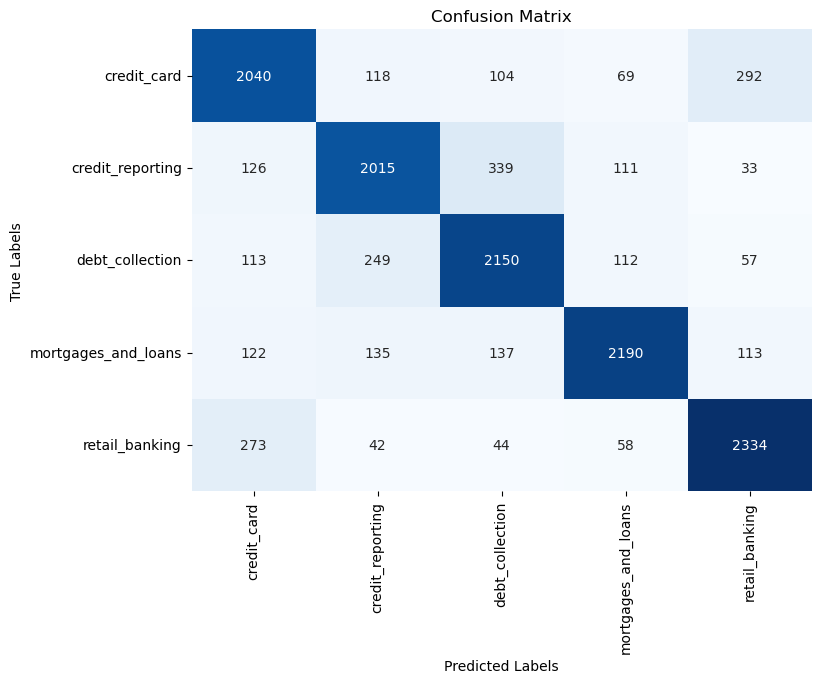

In [50]:
print("Convolutional Neural Network Report with TFIDF Features:")
model_cnn.evaluate(test_loader_cnn_tfidf, target_names=le.classes_)

In [51]:
# save the model
model_cnn.save(os.path.join("models", "cnn_tfidf_model.pth"))


##### Word2Vec

In [52]:
# prepare tensors of word2vec embeddings and move to device
X_train_tensor_w2v = torch.tensor(X_train_w2v.values).float().unsqueeze(1).to(device)  # Shape: (batch_size, 1, seq_length)
y_train_tensor_w2v = torch.tensor(y_train_w2v).long().to(device)
X_test_tensor_w2v = torch.tensor(X_test_w2v.values).float().unsqueeze(1).to(device)  # Shape: (batch_size, 1, seq_length)
y_test_tensor_w2v = torch.tensor(y_test_w2v).long().to(device)

# create a data loader
train_dataset_cnn_w2v = TensorDataset(X_train_tensor_w2v, y_train_tensor_w2v)
train_loader_cnn_w2v = DataLoader(train_dataset_cnn_w2v, batch_size=batch_size, shuffle=True, drop_last=True)

# dataloader for testing
test_dataset_cnn_w2v = TensorDataset(X_test_tensor_w2v, y_test_tensor_w2v)
test_loader_cnn_w2v = DataLoader(test_dataset_cnn_w2v, batch_size=batch_size, shuffle=False, drop_last=True)


In [53]:
# Initialize the model with the correct number of classes
cnn_model_w2v = Convolution(input_size=X_train_tensor_w2v.shape[2], num_classes=num_classes).to(device)
# Train the model
cnn_model_w2v.fit(train_loader_cnn_w2v, epochs=10, lr=0.001)

Epoch 1/10 - Loss: 0.4349486231803894
Epoch 2/10 - Loss: 0.48832952976226807
Epoch 3/10 - Loss: 0.431588351726532
Epoch 4/10 - Loss: 0.30377182364463806
Epoch 5/10 - Loss: 0.25820815563201904
Epoch 6/10 - Loss: 0.45432814955711365
Epoch 7/10 - Loss: 0.27350014448165894
Epoch 8/10 - Loss: 0.44840049743652344
Epoch 9/10 - Loss: 0.37820547819137573
Epoch 10/10 - Loss: 0.2638629674911499


Convolutional Neural Network Report with Word2Vec Features:
Accuracy: 0.8326854066985646
                     precision    recall  f1-score   support

        credit_card       0.82      0.78      0.80      2623
   credit_reporting       0.81      0.82      0.81      2624
    debt_collection       0.83      0.82      0.82      2681
mortgages_and_loans       0.85      0.87      0.86      2697
     retail_banking       0.86      0.87      0.87      2751

           accuracy                           0.83     13376
          macro avg       0.83      0.83      0.83     13376
       weighted avg       0.83      0.83      0.83     13376



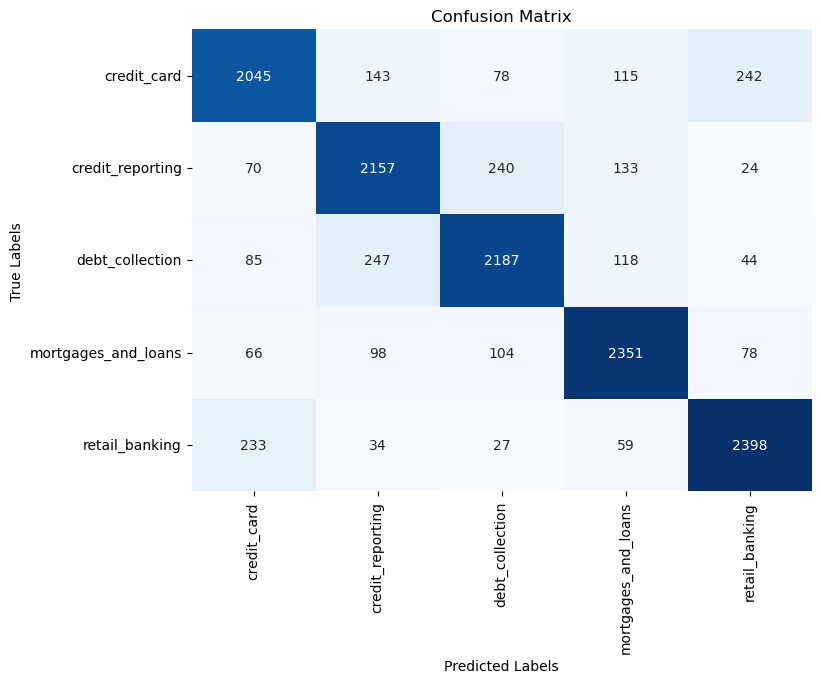

In [54]:
# evaluate the model
print("Convolutional Neural Network Report with Word2Vec Features:")
cnn_model_w2v.evaluate(test_loader_cnn_w2v, target_names=le.classes_)
# save the model
cnn_model_w2v.save(os.path.join("models", "cnn_w2v_model.pth"))

#### Recurrent NN

##### TFIDF

In [55]:
# initialize and train the model
num_classes = len(torch.unique(y_train_tensor))  # Or however you determine the number of classes
rnn_model = Recurrent(input_size=X_train_tensor.shape[2], hidden_size=128, num_classes=num_classes).to(device)
rnn_model.fit(train_loader_cnn_tfidf, epochs=10, lr=0.001)


Epoch 1/10 - Loss: 0.6794942021369934
Epoch 2/10 - Loss: 0.7787114381790161
Epoch 3/10 - Loss: 0.4338347911834717
Epoch 4/10 - Loss: 0.5040968656539917
Epoch 5/10 - Loss: 0.7639877796173096
Epoch 6/10 - Loss: 0.5857053995132446
Epoch 7/10 - Loss: 0.6292343139648438
Epoch 8/10 - Loss: 0.6367805004119873
Epoch 9/10 - Loss: 0.5343838334083557
Epoch 10/10 - Loss: 0.648850679397583


Recurrent Neural Network Report with TFIDF Features:
Accuracy: 0.7792314593301436
                     precision    recall  f1-score   support

        credit_card       0.77      0.72      0.74      2623
   credit_reporting       0.72      0.76      0.74      2624
    debt_collection       0.76      0.74      0.75      2681
mortgages_and_loans       0.83      0.82      0.82      2697
     retail_banking       0.81      0.86      0.83      2751

           accuracy                           0.78     13376
          macro avg       0.78      0.78      0.78     13376
       weighted avg       0.78      0.78      0.78     13376



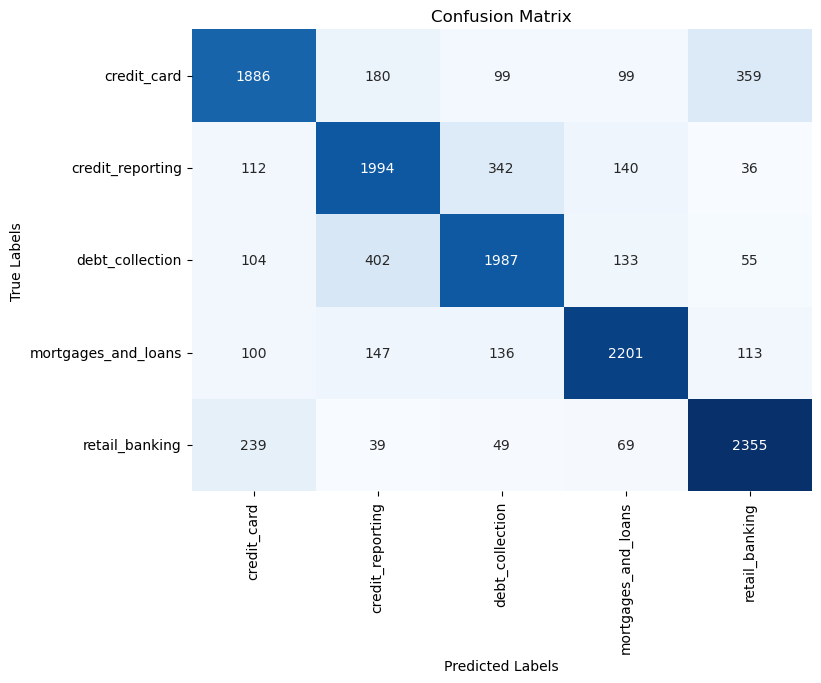

In [56]:
# evaluate the model
print("Recurrent Neural Network Report with TFIDF Features:")
rnn_model.evaluate(test_loader_cnn_tfidf, target_names=le.classes_)
# save the model
rnn_model.save(os.path.join("models", "rnn_tfidf_model.pth"))

##### Word2Vec

In [57]:
# train model
rnn_model = Recurrent(input_size=X_train_tensor_w2v.shape[2], hidden_size=128, num_classes=num_classes).to(device)
rnn_model.fit(train_loader_cnn_w2v, epochs=10, lr=0.001)

Epoch 1/10 - Loss: 0.6793509125709534
Epoch 2/10 - Loss: 0.5726855993270874
Epoch 3/10 - Loss: 0.45906758308410645
Epoch 4/10 - Loss: 0.5745376348495483
Epoch 5/10 - Loss: 0.48897555470466614
Epoch 6/10 - Loss: 0.5436428189277649
Epoch 7/10 - Loss: 0.2611260414123535
Epoch 8/10 - Loss: 0.3797608017921448
Epoch 9/10 - Loss: 0.36116302013397217
Epoch 10/10 - Loss: 0.27991169691085815


Recurrent Neural Network Report with Word2Vec Features:
Accuracy: 0.8338068181818182
                     precision    recall  f1-score   support

        credit_card       0.82      0.79      0.80      2623
   credit_reporting       0.82      0.79      0.80      2624
    debt_collection       0.81      0.82      0.82      2681
mortgages_and_loans       0.86      0.88      0.87      2697
     retail_banking       0.85      0.89      0.87      2751

           accuracy                           0.83     13376
          macro avg       0.83      0.83      0.83     13376
       weighted avg       0.83      0.83      0.83     13376



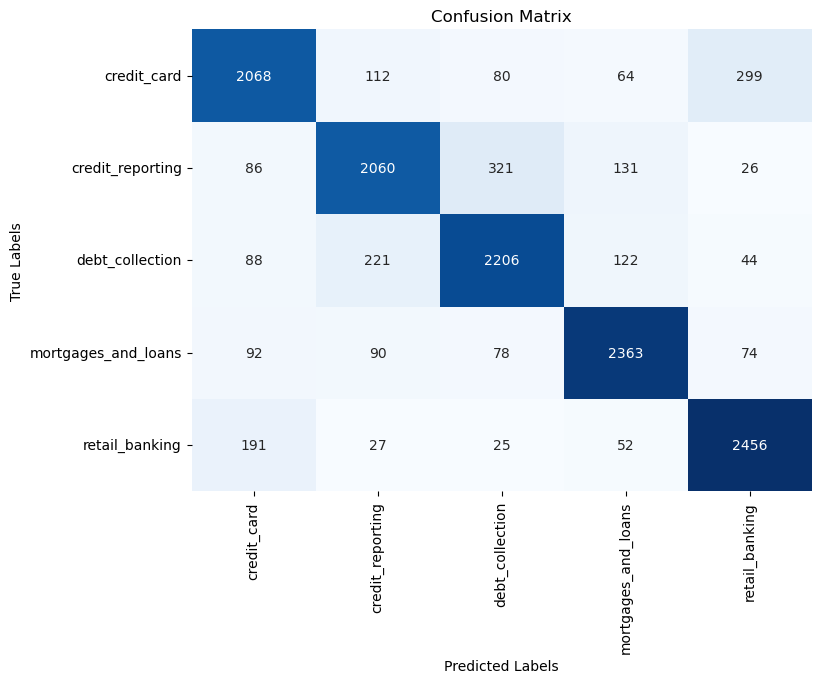

In [58]:
# evaluate model
print("Recurrent Neural Network Report with Word2Vec Features:")
rnn_model.evaluate(test_loader_cnn_w2v, target_names=le.classes_)
# save model
rnn_model.save(os.path.join("models", "rnn_w2v_model.pth"))

#### Bi-LSTM

##### TFIDF

In [59]:
# initialize and train the model
bilstm_model = BiLSTM(input_size=X_train_tensor.shape[2], hidden_size=128, num_classes=num_classes).to(device)
bilstm_model.fit(train_loader_cnn_tfidf, epochs=10, lr=0.001)

Epoch 1/10 - Loss: 0.6290638446807861
Epoch 2/10 - Loss: 0.5074260234832764
Epoch 3/10 - Loss: 0.8321616053581238
Epoch 4/10 - Loss: 0.36198222637176514
Epoch 5/10 - Loss: 0.5196956992149353
Epoch 6/10 - Loss: 0.48795557022094727
Epoch 7/10 - Loss: 0.35900166630744934
Epoch 8/10 - Loss: 0.5539282560348511
Epoch 9/10 - Loss: 0.3143230080604553
Epoch 10/10 - Loss: 0.396471232175827


Bidirectional LSTM Report with TFIDF Features:
Accuracy: 0.8021082535885168
                     precision    recall  f1-score   support

        credit_card       0.81      0.74      0.77      2623
   credit_reporting       0.73      0.82      0.78      2624
    debt_collection       0.82      0.74      0.78      2681
mortgages_and_loans       0.83      0.84      0.84      2697
     retail_banking       0.83      0.86      0.84      2751

           accuracy                           0.80     13376
          macro avg       0.80      0.80      0.80     13376
       weighted avg       0.80      0.80      0.80     13376



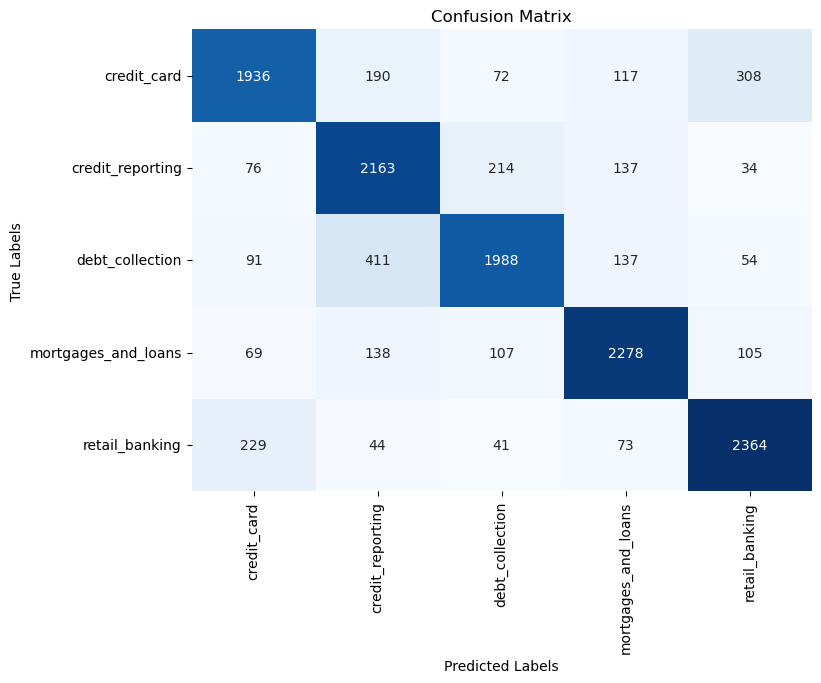

In [60]:
# evaluate the model
print("Bidirectional LSTM Report with TFIDF Features:")
bilstm_model.evaluate(test_loader_cnn_tfidf, target_names=le.classes_)
# save the model
bilstm_model.save(os.path.join("models", "bilstm_tfidf_model.pth"))

##### Word2Vec

In [61]:
# initialize and train the model
bilstm_model_w2v = BiLSTM(input_size=X_train_tensor_w2v.shape[2], hidden_size=128, num_classes=num_classes).to(device)
bilstm_model_w2v.fit(train_loader_cnn_w2v, epochs=10, lr=0.001)


Epoch 1/10 - Loss: 0.3689793050289154
Epoch 2/10 - Loss: 0.3667259216308594
Epoch 3/10 - Loss: 0.45437976717948914
Epoch 4/10 - Loss: 0.4643189013004303
Epoch 5/10 - Loss: 0.6559736132621765
Epoch 6/10 - Loss: 0.40907007455825806
Epoch 7/10 - Loss: 0.42851266264915466
Epoch 8/10 - Loss: 0.4369855225086212
Epoch 9/10 - Loss: 0.34572428464889526
Epoch 10/10 - Loss: 0.33033961057662964


Bidirectional LSTM Report with Word2Vec Features:
Accuracy: 0.8413576555023924
                     precision    recall  f1-score   support

        credit_card       0.82      0.81      0.81      2623
   credit_reporting       0.82      0.82      0.82      2624
    debt_collection       0.85      0.81      0.83      2681
mortgages_and_loans       0.88      0.86      0.87      2697
     retail_banking       0.85      0.90      0.87      2751

           accuracy                           0.84     13376
          macro avg       0.84      0.84      0.84     13376
       weighted avg       0.84      0.84      0.84     13376



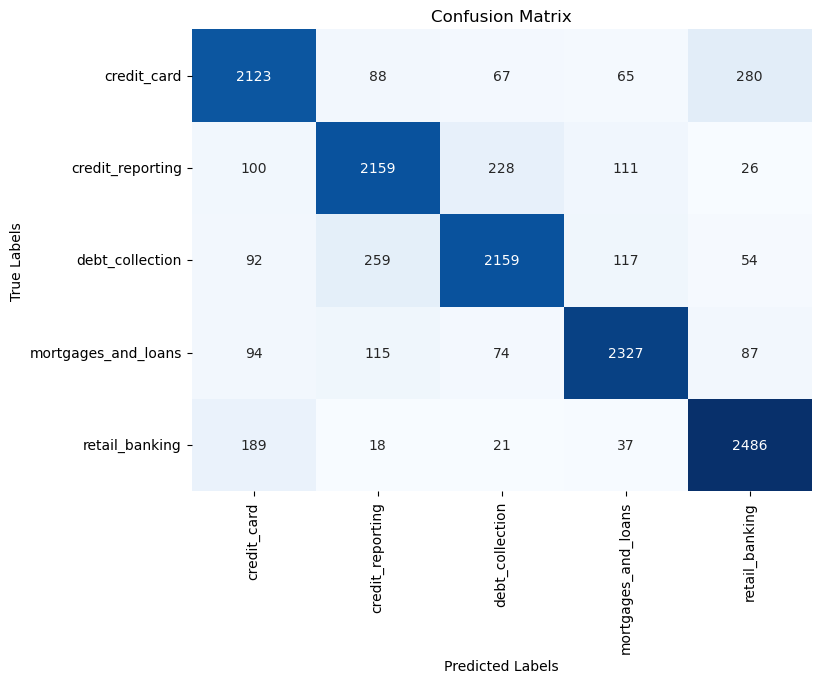

In [62]:
# evaluate the model
print("Bidirectional LSTM Report with Word2Vec Features:")
bilstm_model_w2v.evaluate(test_loader_cnn_w2v, target_names=le.classes_)
# save the model
bilstm_model_w2v.save(os.path.join("models", "bilstm_w2v_model.pth"))
